In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [29]:
# Constant 
eval_year = 12 # number of years we have data. But it typically evaluated through the lifetime of a investment
i_rate = 0.03 # consistant to the NYS EV report: Benefit-Cost Analysis of Electric Vehicle Deployment in New York State

# solar
# grid connection cost excluded (NREL doesn't have a valid estimation)
capex = 1290.806 # $/kW, NREL ATB 2023, see details in the end
fixed_om = 22.529 # $/kW-yr

# RO model results
strike_price = 36 # Model D
premia = 55897 # $/MW-mo
expiration_period = 24 # month

# NetCONE
capacity_netcone = 20700 # $/MW-mo . PJM NetCONE for combined cycle power plant, can also use NYISO capacity market clearing price 

In [30]:
def extend_data(data, eval_year, end_year = 2022):
    # This function extends data to maintain a length of {eval_year} years, which ends at the last hour of {end_year}
    new_data = data.copy()
    start_year = end_year - eval_year + 1
    first_avail_month = data.index[0].to_period('M')
    last_avail_month = data.index[-1].to_period('M')
    head_missing_month = (first_avail_month - pd.Period(f'{start_year}-01', freq='M')).n
    tail_missing_month = (pd.Period(f'{end_year}-12', freq='M') - last_avail_month).n

    if head_missing_month > 0:
        last_copy_month = data.index[-1]
        first_missing_month = data.index[0] - pd.DateOffset(months=1)
        while True:
            if first_missing_month.month == last_copy_month.month:
                break
            else:
                last_copy_month -= pd.DateOffset(months=1)
        while True:
            if first_missing_month.year % 4 == last_copy_month.year % 4:
                break
            else:
                last_copy_month -= pd.DateOffset(years=1)
        
        first_copy_month = last_copy_month - pd.DateOffset(months=head_missing_month)
        #print((last_copy_month.to_period('M') - first_missing_month.to_period('M')).n)
        copy_data = data[data.index.to_period('M').isin(pd.date_range(first_copy_month, last_copy_month, freq='h').to_period('M').unique())]
        copy_data.index = copy_data.index - pd.DateOffset(months=(last_copy_month.to_period('M') - first_missing_month.to_period('M')).n)
        new_data = pd.concat([
            copy_data, data
        ])
    new_data = new_data[new_data.index.year.isin(range(start_year, end_year+1))]
    return new_data

In [31]:
# Load data 
# TODO: change price time series and solar generation series 
# spot market prices, hourly
price = pd.Series()
for year in range(2014, 2024):
    rtp = pd.read_csv(f'./NYISO/NYISO_rtp_5min_localtime_{year}.csv', index_col = 0, parse_dates = [0])['total']
    rtp = rtp.resample('H').mean()
    price = pd.concat([price, rtp])
price = extend_data(price, eval_year, end_year = 2022)
dti = price.index.to_period('M').unique()
display(price)
# solar generation, hourly
solar = pd.read_csv('./NYISO/gridpv_power_hourly_norm_zone_UTC.csv', index_col = 0, parse_dates = [0])
solar = solar.loc[solar.index.year.isin(range(2010, 2023)), 'gridpv.pot.zoneA']
solar = extend_data(solar, eval_year, end_year = 2022)
display(solar)
# NYISO capacity market clearing prices, monthly
capacity_price = pd.read_csv('./NYISO/capacity_market_price.csv', index_col=0, parse_dates = [0], header = [0,1]) # Source: NYSIO ICAP market report
capacity_price = extend_data(capacity_price, eval_year, end_year = 2022)
capacity_price.index = capacity_price.index.to_period('M')
#capacity_price = capacity_price.loc[capacity_price.index.year.isin(range(2014, 2024))]
display(capacity_price)

/var/folders/t4/gd0ch0vd2d9gfydnl1mwjj7c0000gn/T/ipykernel_22305/3438779959.py:4: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  price = pd.Series()


2011-01-01 00:00:00    20.828623
2011-01-01 01:00:00    17.272995
2011-01-01 02:00:00    18.606136
2011-01-01 03:00:00    12.065850
2011-01-01 04:00:00     7.684291
                         ...    
2022-12-31 19:00:00    34.840738
2022-12-31 20:00:00    31.182935
2022-12-31 21:00:00    26.480427
2022-12-31 22:00:00    27.868454
2022-12-31 23:00:00    26.961633
Length: 105192, dtype: float64

2011-01-01 00:00:00    0.000000
2011-01-01 01:00:00    0.000000
2011-01-01 02:00:00    0.000000
2011-01-01 03:00:00    0.000000
2011-01-01 04:00:00    0.000000
                         ...   
2022-12-31 19:00:00    0.008704
2022-12-31 20:00:00    0.000743
2022-12-31 21:00:00    0.000000
2022-12-31 22:00:00    0.000000
2022-12-31 23:00:00    0.000000
Name: gridpv.pot.zoneA, Length: 105192, dtype: float64

NYCA                GHIJ                  NYC                   LI  \
Date    Strip Monthly  Spot Strip Monthly  Spot  Strip Monthly   Spot Strip   
2011-01  0.35    0.12  0.13  2.93    1.70  1.52   3.00    1.70   1.52  0.80   
2011-02  0.35    0.15  0.84  2.93    1.60  1.51   3.00    1.60   1.51  0.80   
2011-03  0.35    0.29  1.09  2.93    1.55  1.54   3.00    1.55   1.54  0.80   
2011-04  0.35    0.40  0.26  2.93    1.54  1.45   3.00    1.54   1.45  0.80   
2011-05  1.30    1.30  1.14  4.63    4.64  5.43  13.10   13.04  13.92  4.95   
...       ...     ...   ...   ...     ...   ...    ...     ...    ...   ...   
2022-08  3.40    3.25  3.47  4.65    3.35  3.74   5.16    3.41   4.41  3.88   
2022-09  3.40    3.19  2.95  4.65    3.42  3.12   5.16    3.42   3.21  3.88   
2022-10  3.40    2.94  2.92  4.65    3.21  3.18   5.16    3.21   3.27  3.88   
2022-11  1.18    1.15  1.54  1.31    1.22  1.54   1.66    1.39   1.54  1.18   
2022-12  1.18    1.80  2.06  1.31    1.80  2.06   1.66    1.80   2.06  1.18   

                       
Date    Monthly  Spot  
2011-01    0.95  0.43  
2011-02    0.75  0.84  
2011-03    0.45  1.09  
2011-04    0.40  0.41  
2011-05    5.00  5.98  
...         ...   ...  
2022-08    6.50  6.71  
2022-09    6.50  6.43  
2022-10    6.40  6.48  
2022-11    1.19  1.54  
2022-12    1.88  2.06  

[144 rows x 12 columns]

In [32]:
dti

PeriodIndex(['2011-01', '2011-02', '2011-03', '2011-04', '2011-05', '2011-06',
             '2011-07', '2011-08', '2011-09', '2011-10',
             ...
             '2022-03', '2022-04', '2022-05', '2022-06', '2022-07', '2022-08',
             '2022-09', '2022-10', '2022-11', '2022-12'],
            dtype='period[M]', length=144)

In [33]:
def calc_discount_rate(i_rate, n): # factor n/12 converts months to years
    return 1/(1+i_rate)**(n/12)

def calc_discount_pv(col, drate):
    return col * drate

def plot_PV(PV):
    x = 0
    bottom = {}
    fig, ax = plt.subplots(figsize = (4.8, 3.6))
    for keys, values in PV.items():
        bottom[keys] = 0
        values = values / 1e6
        for col in values.index:
            if col == 'energy sales':
                plt.bar(x, values.abs().loc[col], bottom = bottom[keys], label = col, width = 0.6, color = 'tab:brown')
                plt.bar(x, [np.nan])
            else: 
                plt.bar(x, values.abs().loc[col], bottom = bottom[keys], label = col, width = 0.6)
            bottom[keys] += values.abs().loc[col]
    
        if keys != 'cost':
            npv = values.sum() + (PV['cost']/1e6).sum()
            plt.text(x, bottom[keys] + 0.1, f'NPV={round(npv,2)}', horizontalalignment='center', verticalalignment='center',)
        
        x+=1
    
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_axisbelow(True)
    plt.grid(True, axis='y')
    
    plt.xticks([0,1,2], ['cost', 'RO benefit', 'capacity benefit'], fontsize = 'large')
    plt.ylabel(r'Present value $\times10^6\$$/MW$_p$', fontsize='large')
    lns, labels = ax.get_legend_handles_labels()
    plt.legend(lns[:-1], labels[:-1], bbox_to_anchor=(1.04, 1), loc="upper left")
    plt.title('Present value of 1MW new construction solar generator')

/var/folders/t4/gd0ch0vd2d9gfydnl1mwjj7c0000gn/T/ipykernel_22305/3954585577.py:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  PV = {'cost': pd.Series(), 'rev_ro': pd.Series(), 'rev_cap': pd.Series()}
/var/folders/t4/gd0ch0vd2d9gfydnl1mwjj7c0000gn/T/ipykernel_22305/3954585577.py:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  PV = {'cost': pd.Series(), 'rev_ro': pd.Series(), 'rev_cap': pd.Series()}
/var/folders/t4/gd0ch0vd2d9gfydnl1mwjj7c0000gn/T/ipykernel_22305/3954585577.py:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  PV = {'cost': pd.Series(), 'rev_ro': pd.Series(), 'rev_cap': pd.Series()}
/var/folders/t4/gd0ch0vd2d9gfydnl1mwjj7c000

{'cost':              CAPEX          FOM
 2011-01 -1290806.0 -1877.416667
 2011-02        NaN -1872.797842
 2011-03        NaN -1868.190380
 2011-04        NaN -1863.594254
 2011-05        NaN -1859.009436
 ...            ...          ...
 2022-08        NaN -1333.100269
 2022-09        NaN -1329.820573
 2022-10        NaN -1326.548945
 2022-11        NaN -1323.285367
 2022-12        NaN -1320.029817
 
 [144 rows x 2 columns],
 'rev_ro':               premium  energy sales
 2011-01  55897.000000   2783.828736
 2011-02  55759.482075   2671.008650
 2011-03  55622.302472   4806.328061
 2011-04  55485.460358   3425.317626
 2011-05  55348.954903   3667.070947
 ...               ...           ...
 2022-08           NaN   4837.031942
 2022-09           NaN   3534.387887
 2022-10           NaN   3387.732164
 2022-11           NaN   2118.261269
 2022-12           NaN   1001.029692
 
 [144 rows x 2 columns],
 'rev_cap':          capacity payment  energy sales
 2011-01               NaN   2783.82

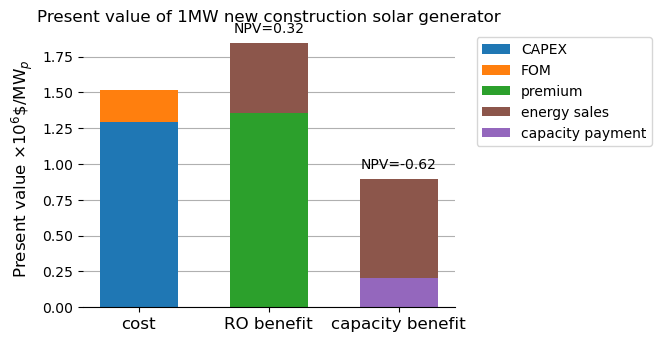

In [34]:
# using NYISO capacity market clearing price
PV = {'cost': pd.Series(), 'rev_ro': pd.Series(), 'rev_cap': pd.Series()}
monthly_discounted_cash = {'cost': pd.DataFrame(index = dti), 'rev_ro': pd.DataFrame(index = dti), 'rev_cap': pd.DataFrame(index = dti)}
monthly_discounted_cash['cost'].loc[dti[0], 'CAPEX'] = - capex * 1000 # 1 MW
discount_rates = pd.Series()

for i, month in enumerate(dti):
    discount_rates.loc[month] = calc_discount_rate(i_rate, i)
    monthly_discounted_cash['cost'].loc[month, 'FOM'] = - fixed_om / 12 * 1000
    # RO
    solar_mo = solar[solar.index.to_period('M') == month]
    price_mo = price[price.index.to_period('M') == month]
    if i <= expiration_period:
        monthly_discounted_cash['rev_ro'].loc[month, 'premium'] = premia
        monthly_discounted_cash['rev_ro'].loc[month, 'energy sales'] = (solar_mo * price_mo).sum()
    else:
        # TODO: please check this: is energy market participation allowed during expiration period? 
        monthly_discounted_cash['rev_ro'].loc[month, 'energy sales'] = (solar_mo * price_mo.clip(upper = strike_price)).sum()

    # capacity market
    if i > expiration_period:
        monthly_discounted_cash['rev_cap'].loc[month, 'capacity payment'] = capacity_price.loc[month, ('NYCA', 'Strip')] * 1000
        # monthly_discounted_cash['rev_cap'].loc[month, 'energy sales'] = (solar_mo * price_mo).sum()
    else:
        monthly_discounted_cash['rev_cap'].loc[month, 'capacity payment'] = np.nan
        # monthly_discounted_cash['rev_cap'].loc[month, 'energy sales'] = np.nan
    monthly_discounted_cash['rev_cap'].loc[month, 'energy sales'] = (solar_mo * price_mo).sum()


for keys, values in monthly_discounted_cash.items():
    for col in values.columns:
        monthly_discounted_cash[keys].loc[:, col] = calc_discount_pv(values[col], discount_rates)
        PV[keys].loc[col] = monthly_discounted_cash[keys].loc[:, col].sum()
display(monthly_discounted_cash)
plot_PV(PV)

/var/folders/t4/gd0ch0vd2d9gfydnl1mwjj7c0000gn/T/ipykernel_22305/3527478638.py:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  PV = {'cost': pd.Series(), 'rev_ro': pd.Series(), 'rev_cap': pd.Series()}
/var/folders/t4/gd0ch0vd2d9gfydnl1mwjj7c0000gn/T/ipykernel_22305/3527478638.py:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  PV = {'cost': pd.Series(), 'rev_ro': pd.Series(), 'rev_cap': pd.Series()}
/var/folders/t4/gd0ch0vd2d9gfydnl1mwjj7c0000gn/T/ipykernel_22305/3527478638.py:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  PV = {'cost': pd.Series(), 'rev_ro': pd.Series(), 'rev_cap': pd.Series()}
/var/folders/t4/gd0ch0vd2d9gfydnl1mwjj7c000

{'cost':              CAPEX          FOM
 2011-01 -1290806.0 -1877.416667
 2011-02        NaN -1872.797842
 2011-03        NaN -1868.190380
 2011-04        NaN -1863.594254
 2011-05        NaN -1859.009436
 ...            ...          ...
 2022-08        NaN -1333.100269
 2022-09        NaN -1329.820573
 2022-10        NaN -1326.548945
 2022-11        NaN -1323.285367
 2022-12        NaN -1320.029817
 
 [144 rows x 2 columns],
 'rev_ro':               premium  energy sales
 2011-01  55897.000000   2783.828736
 2011-02  55759.482075   2671.008650
 2011-03  55622.302472   4806.328061
 2011-04  55485.460358   3425.317626
 2011-05  55348.954903   3667.070947
 ...               ...           ...
 2022-08           NaN   4837.031942
 2022-09           NaN   3534.387887
 2022-10           NaN   3387.732164
 2022-11           NaN   2118.261269
 2022-12           NaN   1001.029692
 
 [144 rows x 2 columns],
 'rev_cap':              capacity  energy sales
 2011-01           NaN           NaN
 20

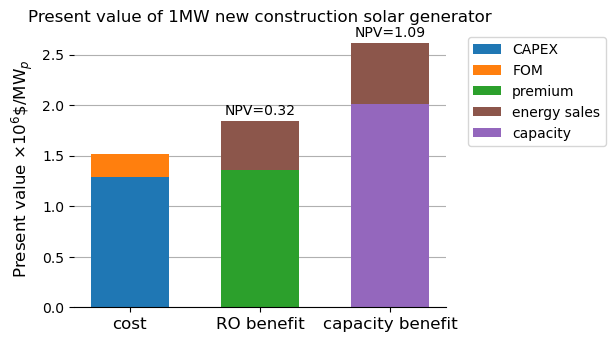

In [ ]:
# # using NetCONE
# PV = {'cost': pd.Series(), 'rev_ro': pd.Series(), 'rev_cap': pd.Series()}
# monthly_discounted_cash = {'cost': pd.DataFrame(index = dti), 'rev_ro': pd.DataFrame(index = dti), 'rev_cap': pd.DataFrame(index = dti)}
# monthly_discounted_cash['cost'].loc[dti[0], 'CAPEX'] = - capex * 1000 # 1 MW
# discount_rates = pd.Series()

# for i, month in enumerate(dti):
#     discount_rates.loc[month] = calc_discount_rate(i_rate, i)
#     monthly_discounted_cash['cost'].loc[month, 'FOM'] = - fixed_om / 12 * 1000
#     # RO
#     solar_mo = solar[solar.index.to_period('M') == month]
#     price_mo = price[price.index.to_period('M') == month]


#     if i <= expiration_period:
#         monthly_discounted_cash['rev_ro'].loc[month, 'premium'] = premia
#         monthly_discounted_cash['rev_ro'].loc[month, 'energy sales'] = (solar_mo * price_mo).sum()
#     else:
#         # TODO: please check this: is energy market participation allowed during expiration period? 
#         monthly_discounted_cash['rev_ro'].loc[month, 'energy sales'] = (solar_mo * price_mo.clip(upper = strike_price)).sum()

#     # capacity market
#     if i > expiration_period:
#         monthly_discounted_cash['rev_cap'].loc[month, 'capacity'] = capacity_netcone
#         monthly_discounted_cash['rev_cap'].loc[month, 'energy sales'] = (solar_mo * price_mo).sum()
#     else:
#         monthly_discounted_cash['rev_cap'].loc[month, 'capacity'] = np.nan
#         monthly_discounted_cash['rev_cap'].loc[month, 'energy sales'] = np.nan
#     # monthly_discounted_cash['rev_cap'].loc[month, 'energy sales'] = (solar_mo * price_mo).sum()



# for keys, values in monthly_discounted_cash.items():
#     for col in values.columns:
#         monthly_discounted_cash[keys].loc[:, col] = calc_discount_pv(values[col], discount_rates)
#         PV[keys].loc[col] = monthly_discounted_cash[keys].loc[:, col].sum()
# display(monthly_discounted_cash)
# plot_PV(PV)

In [36]:
# NREL ATB 2023, 
## scenario: 
            #wind onshore: conservative, default class 4 tech 1 
            #wind offshore: conservative, default class 3
            #PV: conservative, default class 5
            #btmPV: residential PV, moderate, default class 5
            #natgas: NG combined cycle (F-frame)
            #natgas: higher VOM cost using simple cycle (F-frame)
            
# Social cost of CO2 (SC-CO2): 
## Interagency Working Group on Social Cost of Greenhouse Gases, United States Government, Technical Update of the Social Cost of Carbon for Regulatory Impact Analysis Under Executive Order 12866
## Using 3% discount rate, consistent with E3 study and the recommendation of Commission's BCA order. 2007$

# distribution upgrade cost
## used utility DRVs (NY DPS), base case distribution cost calculations. 
## STATE OF NEW YORK DEPARTMENT OF PUBLIC SERVICE. (2018). Draft Staff Whitepaper Regarding VDER Compensation for Avoided Distribution Costs
## The data can be found in CLCPA scoping plan Supplement-Annex-1, input exce 


            
# capex
capex = { # $/kW
    2021: {
        'wind onshore': 1363,
        'wind offshore': 4072.787, 
        'pv': 1290.806,
        'btmpv': 2858.729,
        'natgas': 1247.535,
    },
    2030: {
        'wind onshore': 1273.957,
        'wind offshore': 3532.543, 
        'pv': 1205.956,
        'btmpv': 2504.711,
        'natgas': 1181.269,
        
    },
    
    2040: {
        'wind onshore': 1188.055,
        'wind offshore': 3327.623, 
        'pv': 1010.689,
        'btmpv': 2011.029,
        'natgas': 1098.354,
    },
    
    2050: {
        'wind onshore': 1102.154,
        'wind offshore': 3204.2,
        'pv': 829.208,
        'btmpv': 1576.706,
        'natgas': 1015.55,
        
    }
}

# fixed opex
fixed_om = { # $/kW-yr
    2021: {
        'wind onshore': 30.3,
        'wind offshore': 122.88,
        'pv': 22.529,
        'btmpv': 30.328,
        'natgas': 31.1
        
    },
    
    2030: {
        'wind onshore': 28.65,
        'wind offshore': 108.711,
        'pv': 19.932,
        'btmpv': 26.907,
        'natgas': 29.7
        
    },
    
    2040: {
        'wind onshore': 27.619,
        'wind offshore': 101.825,
        'pv': 17.703,
        'btmpv': 22.205,
        'natgas': 27.9
        
    },
    
    2050: {
        'wind onshore': 26.588,
        'wind offshore': 97.512, 
        'pv': 15.794,
        'btmpv': 18.069,
        'natgas': 26.1
    }
} 

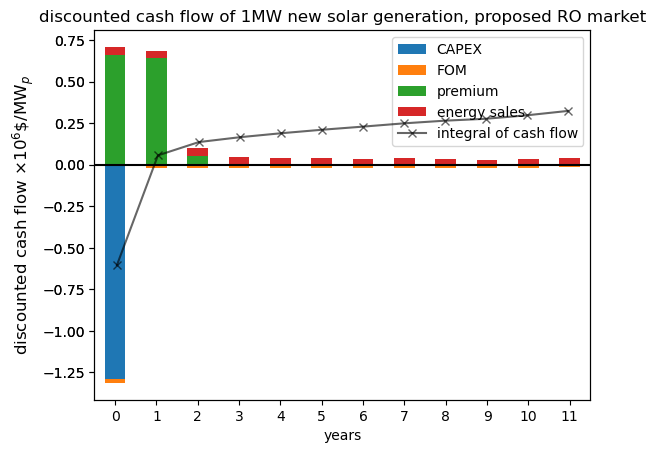

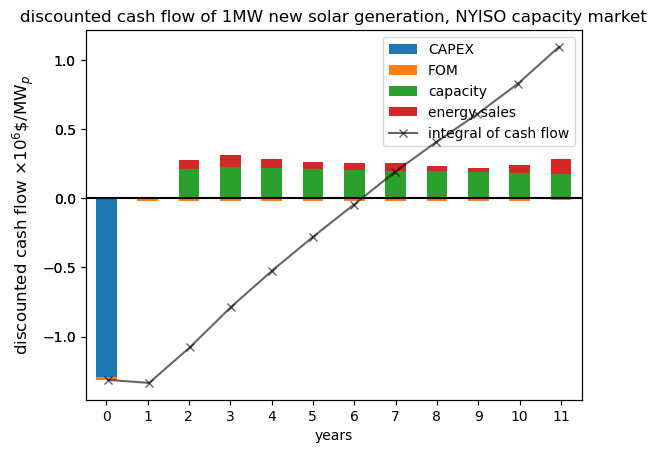

In [37]:
def plot_cashflow(cost_col, rev_col, market):
    flow = pd.concat([cost_col, rev_col], axis=1)
   
    flow = flow.resample('Y').sum()
    fig, ax = plt.subplots()
    flow.reset_index().plot.bar(ax=ax, stacked = True)
   
    ax2 = ax.twiny()
    flow.sum(axis=1).cumsum().reset_index().plot(ax=ax2, marker = 'x', color='black', alpha = 0.6, label = 'integral of cash flow')

    handles, labels = ax.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    handles.extend(handles2)
    labels.extend(['integral of cash flow'])
    ax.legend(handles, labels)
    ax2.get_legend().remove()
    ax.set_xticks(range(eval_year), range(eval_year), rotation = 0)
    ax2.set_xticks([])
    plt.axhline(0, color='black')
    ax.set_xlabel('years')
    plt.ylabel(r'discounted cash flow $\times10^6\$$/MW$_p$', fontsize='large')
    plt.title(f'discounted cash flow of 1MW new solar generation, {market}')
    plt.show()
 
plot_cashflow(monthly_discounted_cash['cost'] / 1e6, monthly_discounted_cash['rev_ro'] / 1e6, 'proposed RO market')
plot_cashflow(monthly_discounted_cash['cost'] / 1e6, monthly_discounted_cash['rev_cap'] / 1e6, 'NYISO capacity market')